In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import CCA


CCA and ZETA

In [5]:
def get_CCA(U, V, d):
    U = U.swapaxes(1,2).reshape(-1, d) 
    V = V.swapaxes(1,2).reshape(-1, d)

    cca = CCA(n_components=d)
    cca.fit(U, V)
    U_c, V_c = cca.transform(U, V)
    corrs = [np.corrcoef(U_c[:, i], V_c[:, i])[0, 1] for i in range(d)]  
    return np.mean(corrs)

ds = np.arange(2,11)
ls_zeta_pca = []
ls_zeta_sca = []
ls_zeta_ksca = []

ls_CCA_sca_ksca = []
ls_CCA_pca_ksca = []
ls_CCA_pca_sca = []
for d in ds:
    Y_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_spikes_tt/Y_pca_train_{d}d.npy')
    Y_sca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_linear_tt/Y_{d}d.npy')
    Y_ksca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_tt/projection_{d}d_gaussian.npy')

    ls_zeta_pca.append(compute_S_all_pairs(jnp.array(Y_pca)))
    ls_zeta_sca.append(compute_S_all_pairs(jnp.array(Y_sca)))
    ls_zeta_ksca.append(compute_S_all_pairs(jnp.array(Y_ksca)))
   
    ls_CCA_sca_ksca.append(get_CCA(Y_sca, Y_ksca, d)) 
    ls_CCA_pca_ksca.append(get_CCA(Y_pca, Y_ksca, d)) 
    ls_CCA_pca_sca.append(get_CCA(Y_pca, Y_sca, d)) 


/Users/ariellerosinski/miniforge3/envs/sca_project/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/ariellerosinski/miniforge3/envs/sca_project/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [6]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES/TRAIN'

np.save(f'{main_path}/ls_zeta_pca', ls_zeta_pca)
np.save(f'{main_path}/ls_zeta_sca', ls_zeta_sca)
np.save(f'{main_path}/ls_zeta_ksca', ls_zeta_ksca)
np.save(f'{main_path}/ls_CCA_sca_ksca', ls_CCA_sca_ksca)
np.save(f'{main_path}/ls_CCA_pca_ksca', ls_CCA_pca_ksca)
np.save(f'{main_path}/ls_CCA_pca_sca', ls_CCA_pca_sca)

VAR EXPLAINED 

In [26]:
A_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/A_train_softNormMax_centerFalse_pcaFalse.npy')
A_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/A_test_softNormMax_centerFalse_pcaFalse.npy')

ls_var_pca = []
ls_var_sca = []
ls_var_ksca = []
ds = np.arange(2,11)
for d in ds:
    X_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_train_softNormMax_centerTrue_pcaFalse.npy')
    X_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_test_softNormMax_centerTrue_pcaFalse.npy')
    PCs = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_psth_tt/PCs_{d}d.npy')
    var_pca = var_explained(X_test, PCs.T)
    ls_var_pca.append(var_pca)

    U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_psth_linear_tt/U_{d}d.npy')
    U_qr, _ = jnp.linalg.qr(U)   
    var_sca = var_explained(X_test, U_qr)
    ls_var_sca.append(var_sca)

    X_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_train_softNormMax_centerFalse_pcaFalse.npy')
    X_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_test_softNormMax_centerFalse_pcaFalse.npy')
    params = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_psth_kernel_tt/params_{d}d_gaussian.npy', allow_pickle=True).tolist()
    _, _, _, _, alpha  = get_alpha(params, A_train, X_train, K_X_Y_squared_exponential, d)
    _, _, l2, scale = get_params(params, kernel_function=K_X_Y_squared_exponential)
    #var_ksca = var_explained_kernel(alpha, K_X_Y_squared_exponential, A_train, X_train, l2, scale, compute_matrix=False)
    var_ksca_test = var_explained_kernel(alpha, K_X_Y_squared_exponential, A_train, X_train, l2, scale, A_test=A_test, X_test=X_test, test=True, compute_matrix=False)
    ls_var_ksca.append(var_ksca_test)
   


In [27]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/PSTH/TEST'

np.save(f'{main_path}/ls_var_pca', ls_var_pca)
np.save(f'{main_path}/ls_var_sca', ls_var_sca)
np.save(f'{main_path}/ls_var_ksca', ls_var_ksca)

In [28]:
ls_var_pca

[0.2006038333590302,
 0.26555285421878416,
 0.31745581958598684,
 0.36474453348710506,
 0.39402645436999234,
 0.4294605632366906,
 0.4651932876753543,
 0.4940650623217055,
 0.5140840437788284]

In [29]:
ls_var_sca

[0.16672001178514254,
 0.19417040233949057,
 0.20829065172931607,
 0.21879307046634333,
 0.2256927497742163,
 0.3609931153540702,
 0.24361630412141522,
 0.38707345849198654,
 0.38930379360031725]

In [30]:
ls_var_ksca

[Array(0.09267665, dtype=float32),
 Array(0.11159353, dtype=float32),
 Array(0.11999106, dtype=float32),
 Array(0.1299927, dtype=float32),
 Array(0.20146811, dtype=float32),
 Array(0.22137956, dtype=float32),
 Array(0.2381259, dtype=float32),
 Array(0.25915214, dtype=float32),
 Array(0.26466522, dtype=float32)]

Linear Regression

In [36]:
Y_sca.shape

(48, 10, 35)

In [69]:
Y_pca.shape

(621, 2, 35)

In [78]:
#behaviour_ = 'torques'
#behaviour = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/{behaviour_}.npy')[60:]
behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_behavior.npy').swapaxes(1,2)[:1100]
split = 150
lag = 5

ls_r2_ksca = []
ls_r2_sca = []
ls_r2_pca = []
ds = np.arange(2,11)

y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
for d in ds:
    Y_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_spikes_tt/Y_pca_train_{d}d.npy')
    Y_sca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_linear_tt/Y_{d}d.npy')
    Y_ksca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_tt/projection_{d}d_gaussian.npy')

    X_train = Y_ksca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_ksca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test)[0] )

    X_train = Y_sca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_sca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test)[0] )


    X_train = Y_pca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_pca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test)[0] )


#X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)[60:]
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)[:1100]
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
r2_X = get_reg(X_train,y_train,X_test, y_test)[0]

In [79]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES/TRAIN'

behaviour_ = 'hand_vel'
np.save(f'{main_path}/ls_r2_pca_{behaviour_}', ls_r2_pca)
np.save(f'{main_path}/ls_r2_sca_{behaviour_}', ls_r2_sca)
np.save(f'{main_path}/ls_r2_ksca_{behaviour_}', ls_r2_ksca)
np.save(f'{main_path}/r2X_{behaviour_}', r2_X)

# np.save(f'{main_path}/ls_r2_pca_{behaviour_}', ls_r2_pca)
# np.save(f'{main_path}/ls_r2_sca_{behaviour_}', ls_r2_sca)
# np.save(f'{main_path}/ls_r2_ksca_{behaviour_}', ls_r2_ksca)
# np.save(f'{main_path}/r2X_{behaviour_}', r2_X)

In [80]:
ls_r2_pca

[0.18912251459259372,
 0.2303606335998788,
 0.2775906060639408,
 0.30022962118455554,
 0.334575929632493,
 0.365937516819946,
 0.38483978630319177,
 0.4288722643871881,
 0.4369881678802076]

In [81]:
ls_r2_sca

[0.2188434622958067,
 0.22534200921047776,
 0.2437807388235086,
 0.23224691179432133,
 0.4148500585005763,
 0.4450108171803289,
 0.47694775247677923,
 0.5231705659575826,
 0.5009425017510047]

In [82]:
ls_r2_ksca

[0.23939574875496133,
 0.24100179167453561,
 0.255635223923489,
 0.2582695357802443,
 0.4322999065269529,
 0.45249012799377764,
 0.4764053871819354,
 0.5266690960142377,
 0.5292736080984619]

ENDS HERE 

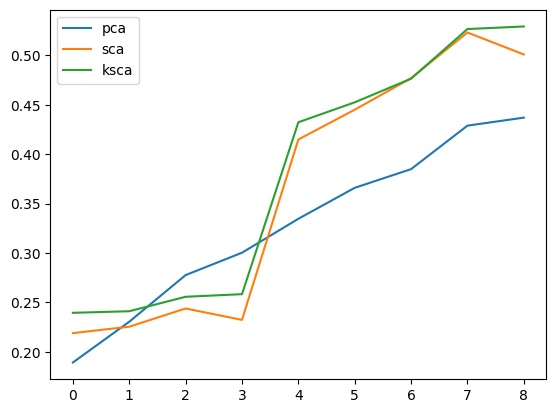

In [83]:
plt.figure()
plt.plot(ls_r2_pca, label='pca')
plt.plot(ls_r2_sca, label='sca')
plt.plot(ls_r2_ksca, label='ksca')
plt.legend()

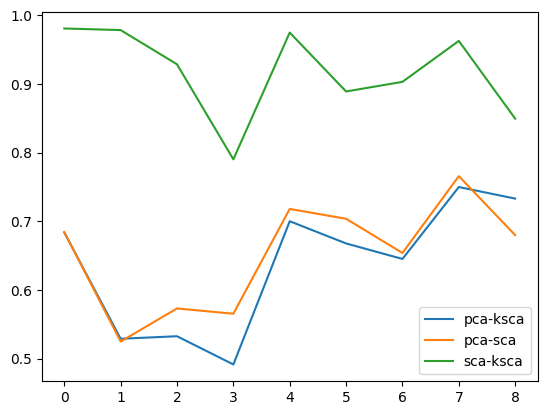

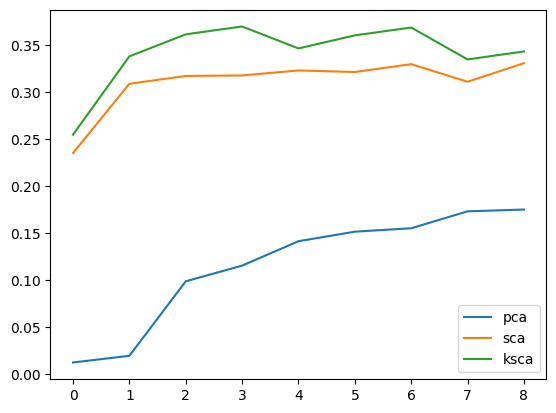

In [7]:
plt.plot(ls_CCA_pca_ksca, label='pca-ksca')
plt.plot(ls_CCA_pca_sca, label='pca-sca')
plt.plot(ls_CCA_sca_ksca, label='sca-ksca')
plt.legend()

plt.figure()
plt.plot(ls_zeta_pca, label='pca')
plt.plot(ls_zeta_sca, label='sca')
plt.plot(ls_zeta_ksca, label='ksca')
plt.legend()